In [8]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
%pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 📊 Dataset Overview

This notebook works with a dataset containing WiFi signal strengths used to estimate 3D positions (x, y, z). Each row corresponds to a WiFi fingerprint and its known physical coordinates. The aim is to train a machine learning model that can predict the physical location based on the received signal strengths.

## 📥 Importing Libraries & Loading the Dataset

We begin by loading the necessary Python libraries for data manipulation, machine learning, and visualization. Then, we read the dataset from an Excel file and examine its structure.


In [19]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === Load Dataset ===
raw_data = pd.read_excel("02-3D Position Estimation using WiFi Fingerprinting.xlsx")
print("Data loaded. Shape:", raw_data.shape)

Data loaded. Shape: (1984, 215)


## 🛠️ Preprocessing and Feature Selection

Only the columns that represent WiFi signal strengths (ending with `_signal`) are selected as features. These values include many zeros, which typically mean "no signal". We replace them with -105 dBm, a commonly used low RSSI threshold to indicate signal loss.

Additionally, we drop any access points (columns) where all values are -105, as they do not contribute meaningful information.


In [ ]:
# === Feature & Target Separation ===
wifi_features = [c for c in raw_data.columns if '_signal' in c]
X_data = raw_data[wifi_features]
Y_data = raw_data[['x', 'y', 'z']]

# === Signal Adjustment ===
X_data = X_data.replace(0, -105)
X_data = X_data.loc[:, (X_data != -105).any(axis=0)]
print(f"Remaining active signal features: {X_data.shape[1]}")

## 🔀 Train-Test Split

We split the dataset into training and testing sets using a 70/30 ratio, as required. This ensures we can fairly evaluate the model’s performance on unseen data.

## 📏 Feature Scaling

Since WiFi signal strengths vary widely in scale, we apply standard normalization using `StandardScaler`. This transformation is important for distance-based models like Random Forest and improves convergence and performance.


In [10]:
# === Train-Test Split ===
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, test_size=0.3, random_state=13
)

# === Feature Scaling ===
scaler_obj = StandardScaler()
X_train_scaled = scaler_obj.fit_transform(X_train)
X_test_scaled = scaler_obj.transform(X_test)

Remaining active signal features: 100


## 🌲 Training a Random Forest Model

We train a Random Forest Regressor, named `WiFiForestRegressor`, with 150 trees. This model is well-suited for handling high-dimensional, noisy datasets like WiFi signal maps.


In [11]:
# === Model Training ===
print("Training WiFiForestRegressor model...")
wifi_model = RandomForestRegressor(n_estimators=150, random_state=13)
wifi_model.fit(X_train_scaled, Y_train)

Training WiFiForestRegressor model...


RandomForestRegressor(n_estimators=150, random_state=13)

In [12]:
# === Prediction ===
Y_train_pred = wifi_model.predict(X_train_scaled)
Y_test_pred = wifi_model.predict(X_test_scaled)

## 🌲 Training a Random Forest Model

We train a Random Forest Regressor, named `WiFiForestRegressor`, with 150 trees. This model is well-suited for handling high-dimensional, noisy datasets like WiFi signal maps.


In [13]:
# === Distance Evaluation ===
train_distance = np.mean(np.linalg.norm(Y_train_pred - Y_train.values, axis=1))
test_distance = np.mean(np.linalg.norm(Y_test_pred - Y_test.values, axis=1))
print(f"[Train] Avg. Euclidean Distance: {train_distance:.2f}")
print(f"[Test] Avg. Euclidean Distance: {test_distance:.2f}")

[Train] Avg. Euclidean Distance: 0.18
[Test] Avg. Euclidean Distance: 0.46


## 📌 Top WiFi Access Points

Using the model's feature importance scores, we visualize the most informative WiFi access points. This can provide insights into which signals contribute most to accurate positioning.


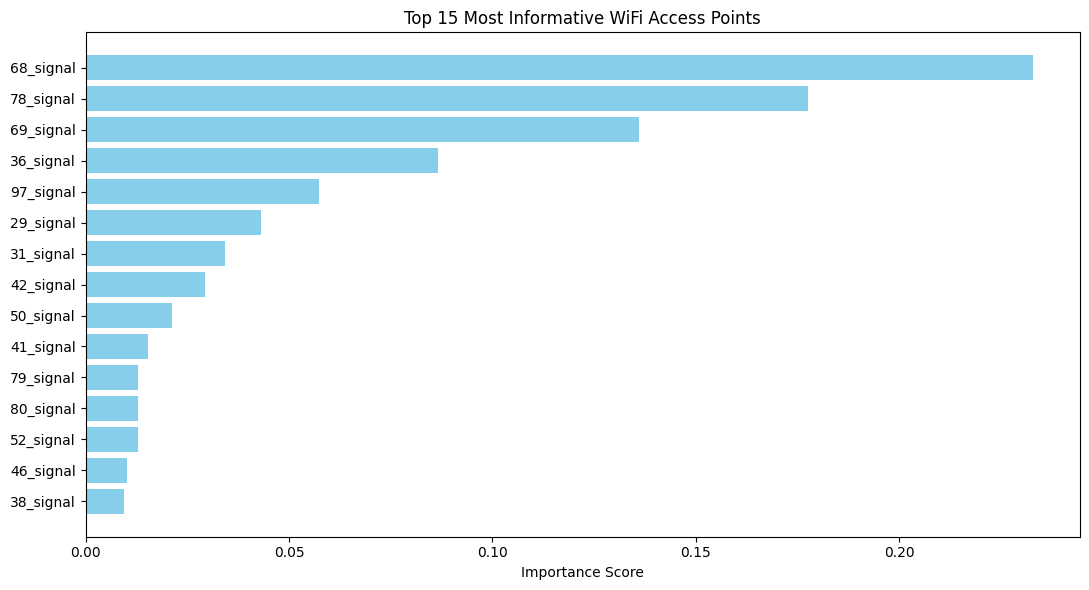

In [14]:
# === Feature Importance ===
importances = wifi_model.feature_importances_
importance_df = pd.DataFrame({
    'WiFi_AP': X_data.columns,
    'Relevance': importances
}).sort_values(by='Relevance', ascending=False)

plt.figure(figsize=(11, 6))
plt.barh(importance_df['WiFi_AP'][:15], importance_df['Relevance'][:15], color='skyblue')
plt.title("Top 15 Most Informative WiFi Access Points")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 🧭 3D Visualization of True vs Predicted Locations

To visually inspect prediction performance, we plot the true and predicted positions in 3D space using Plotly. Red points represent the model's predictions, while blue points are the actual coordinates.


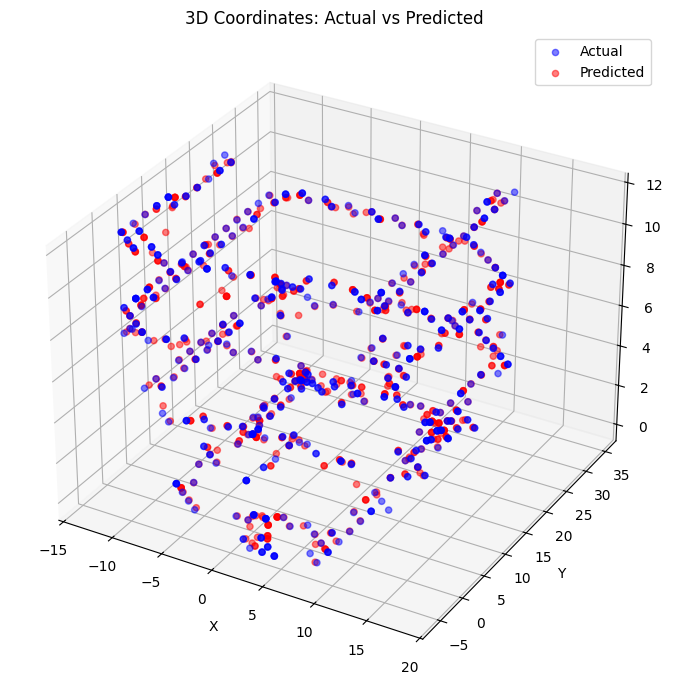

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Y_test['x'], Y_test['y'], Y_test['z'], label='Actual', c='blue', alpha=0.5)
ax.scatter(Y_test_pred[:, 0], Y_test_pred[:, 1], Y_test_pred[:, 2], label='Predicted', c='red', alpha=0.5)

ax.set_title("3D Coordinates: Actual vs Predicted")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()